In [1]:
import deepSI
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
import matplotlib
from matplotlib import cm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

linewidth = 3.320
reducesize = 0.85
fig_fontsize = (10*19/28)*reducesize
matplotlib.rcParams.update({'font.size': fig_fontsize})
dpi = 200
pad = 0.4
nfbase = 40
systemsdir = 'systems/'

class My_system(deepSI.System_ss): 
    def __init__(self):
        super(My_system,self).__init__(nx=2)
    def f(self, x, u):
        return x[0]/(1.2+x[1]**2)+x[1]*0.4, x[1]/(1.2+x[0]**2)+x[0]*0.4+u #some non-linear function
    def h(self, x, u):
        return x[0]#add some noise

def get_data(Nsamples,noise_level=0.1):
    base_sys = My_system()
    ystd = 0.8220855854410254 #assumes U(-2,2) input
    data = base_sys.apply_experiment(deepSI.System_data(u=np.random.uniform(low=-2,high=2,size=Nsamples)))
    data.y += base_sys.random.normal(scale=ystd*noise_level, size=data.y.shape[0])
    return data


## General Great Performance

 * Encoder Multi
 * linear approach (ARX and SS)

In [2]:
def get_base_results(load=True,timeout=1000):
    train, val, test = get_data(10000), get_data(3000), get_data(10000,noise_level=0)
    
    if load:
        arx_s = deepSI.load_system(systemsdir+'arx-s-base')
        arx_s._dt = None
        arx_s.feedthrough=False
    else:
        arx_v, arx_s, _, _ = deepSI.fit_systems.grid_search(deepSI.fit_systems.Sklearn_io_linear, train,
            sys_dict_choices=dict(na=list(range(1,10)),nb=list(range(1,10))),
            fit_dict_choices={},
            sim_val=val,
            RMS=False,
            verbose=2)
        arx_s.save_system('arx-s-base')
    arx_t = arx_s.apply_experiment(test).NRMS(test)
    
    if load:
        ssl_s = deepSI.load_system(systemsdir+'ssl-s-base')
        ssl_s._dt = None
        ssl_s.feedthrough=False
    else:
        ssl_v, ssl_s, _, _ = deepSI.fit_systems.grid_search(deepSI.fit_systems.SS_linear, train,
            sys_dict_choices=dict(nx=list(range(1,10))),
            fit_dict_choices=dict(SS_f=[5,10,20,40]),
            sim_val=val,
            RMS=False,
            verbose=2)
        ssl_s.save_system('ssl-s-base')
    ssl_s.k0 = None
    ssl_t = ssl_s.apply_experiment(test).NRMS(test)

    if load:
        sse_e_s = deepSI.load_system(systemsdir+'sse-e-base-last')
        sse_e_s._dt = None
        sse_e_s.feedthrough=False
        sse_e_s_best = deepSI.load_system(systemsdir+'sse-e-base-best')
        sse_e_s_best._dt = None
        sse_e_s_best.feedthrough=False
        sse_e_t = sse_e_s_best.apply_experiment(test).NRMS(test)
    else:
        sse_e_s = deepSI.fit_systems.SS_encoder(nx=4)
        sse_e_s.fit(train,sim_val=val,loss_kwargs=dict(nf=nfbase),concurrent_val=True,timeout=timeout)
        sse_e_s.save_system('sse-e-base-best')
        sse_e_t = sse_e_s.apply_experiment(test).NRMS(test)
        sse_e_s.checkpoint_load_system('_last')
        sse_e_s.save_system('sse-e-base-last')
    
    return arx_s, arx_t, ssl_s, ssl_t, sse_e_s, sse_e_t

arx_s, arx_t, ssl_s, ssl_t, sse_e_s, sse_e_t = get_base_results(load=True,timeout=2000)

C:\Users\s143190\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
from tabulate import tabulate
d = [['name','NRMS test'],
          ['ARX', arx_t],
          ['SS linear',ssl_t],
          ['SS encoder overlap',sse_e_t]]
tab = tabulate(d,headers="firstrow",tablefmt='plain')
print(tab)
tab = tabulate(d,headers="firstrow",tablefmt='latex')
print(tab)
tab = tabulate(d,headers="firstrow",tablefmt='github')
print(tab)
# del arx_s, arx_t, ssl_s, ssl_t, sse_e_s, sse_e_t

name                  NRMS test
ARX                   0.416573
SS linear             0.416806
SS encoder overlap    0.0186639
\begin{tabular}{lr}
\hline
 name               &   NRMS test \\
\hline
 ARX                &   0.416573  \\
 SS linear          &   0.416806  \\
 SS encoder overlap &   0.0186639 \\
\hline
\end{tabular}
| name               |   NRMS test |
|--------------------|-------------|
| ARX                |   0.416573  |
| SS linear          |   0.416806  |
| SS encoder overlap |   0.0186639 |


## Optimization time (Fig 2. and Table 1)

 * Encoder (e&m)
 * par (e&m)
 * NARX

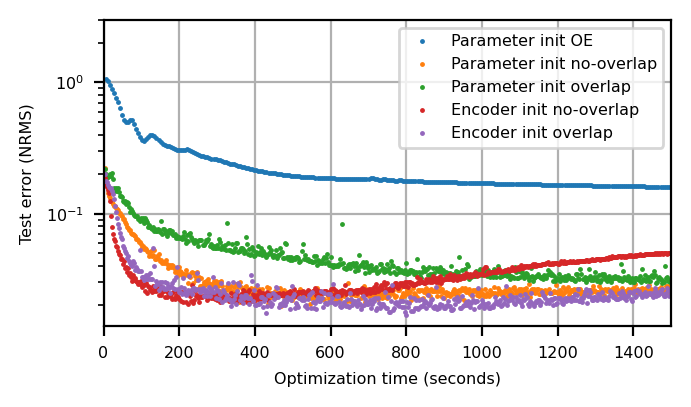

Combination                NRMS test
Parameter init OE          15.9%
Parameter init no-overlap  2.0%
Parameter init overlap     3.0%
Encoder init no-overlap    2.1%
Encoder init overlap       1.7%
\begin{tabular}{ll}
\hline
 Combination               & NRMS test   \\
\hline
 Parameter init OE         & 15.9\%       \\
 Parameter init no-overlap & 2.0\%        \\
 Parameter init overlap    & 3.0\%        \\
 Encoder init no-overlap   & 2.1\%        \\
 Encoder init overlap      & 1.7\%        \\
\hline
\end{tabular}
| Combination               | NRMS test   |
|---------------------------|-------------|
| Parameter init OE         | 15.9%       |
| Parameter init no-overlap | 2.0%        |
| Parameter init overlap    | 3.0%        |
| Encoder init no-overlap   | 2.1%        |
| Encoder init overlap      | 1.7%        |


In [4]:
def get_optimization_sys(timeout = 1500, load=True):
    train, val, test = get_data(10000), get_data(3000), get_data(10000,noise_level=0)

    if load:
        l = lambda f: deepSI.load_system(systemsdir+f)
        return [l(k) for k in ['opt-narx-s-last', 'opt-sse-e-last', 'opt-sse-m-last', 'opt-ssp-e-last','opt-ssp-m-last','opt-ssp-OE-last']]

    narx_s = deepSI.fit_systems.Torch_io_siso(5,5)
    narx_s.fit(train,sim_val=test,concurrent_val=True,timeout=timeout)
    narx_s.checkpoint_load_system('_last')
    narx_s.save_system('opt-narx-s-last')
    
    sse_e_s = deepSI.fit_systems.SS_encoder(nx=4)
    sse_e_s.fit(train,sim_val=test,loss_kwargs=dict(nf=40),concurrent_val=True,timeout=timeout)
    sse_e_s.checkpoint_load_system('_last')
    sse_e_s.save_system('opt-sse-e-last')
    
    sse_m_s = deepSI.fit_systems.SS_encoder(nx=4)
    sse_m_s.__dict__ = torch.load('SS_encoder_mult.pth')
    sse_m_s.fit(train,sim_val=test,loss_kwargs=dict(nf=40,dilation=40),concurrent_val=True,timeout=timeout)
    sse_m_s.checkpoint_load_system('_last')
    sse_m_s.save_system('opt-sse-m-last')
  
    ssp_e_s = deepSI.fit_systems.encoders.SS_par_start(nx=4)
    ssp_e_s.fit(train,sim_val=test,loss_kwargs=dict(nf=40),concurrent_val=True,timeout=timeout)
    ssp_e_s.checkpoint_load_system('_last')
    ssp_e_s.save_system('opt-ssp-e-last')
    
    ssp_m_s = deepSI.fit_systems.encoders.SS_par_start(nx=4)
    ssp_m_s.fit(train,sim_val=test,loss_kwargs=dict(nf=40,dilation=40),concurrent_val=True,timeout=timeout)
    ssp_m_s.checkpoint_load_system('_last')
    ssp_m_s.save_system('opt-ssp-m-last')
    
    ssp_OE_s = deepSI.fit_systems.encoders.SS_par_start(nx=4)
    ssp_OE_s.fit(train,sim_val=test,loss_kwargs=dict(nf=len(train)),concurrent_val=True,timeout=timeout)
    ssp_OE_s.checkpoint_load_system('_last')
    ssp_OE_s.save_system('opt-ssp-OE-last')

    return narx_s, sse_e_s, sse_m_s, ssp_e_s, ssp_m_s, ssp_OE_s

narx_s, sse_e_s, sse_m_s, ssp_e_s, ssp_m_s, ssp_OE_s = get_optimization_sys(load=True)

f = lambda x,name: plt.semilogy(x.time,x.Loss_val,'.',label=name,markersize=1.5)
plt.figure(figsize=(linewidth,1.9),dpi=dpi)
# plt.ylim(0,0.4)
f(ssp_OE_s,'Parameter init OE')
# f(narx_s,'ANN NARX')
f(ssp_m_s,'Parameter init no-overlap')
f(ssp_e_s,'Parameter init overlap')
f(sse_m_s,'Encoder init no-overlap')
f(sse_e_s,'Encoder init overlap')


plt.grid()
plt.legend()
plt.xlabel('Optimization time (seconds)')
plt.ylabel('Test error (NRMS)')
plt.xlim(0,1500)
plt.ylim(None,3)
plt.tight_layout(pad=pad)
plt.savefig('figs/time-comp.pdf')
plt.show()

from tabulate import tabulate
form = lambda f: f'{f:.1%}'
#           ['ARX', form(arx_t)],
#           ['SS linear',form(ssl_t)],
#           ['NARX', form(min(narx_s.Loss_val))],
d = [['Combination','NRMS test'],
          ['Parameter init OE',form(min(ssp_OE_s.Loss_val))],
          ['Parameter init no-overlap',form(min(ssp_m_s.Loss_val))],
          ['Parameter init overlap',form(min(ssp_e_s.Loss_val))],
          ['Encoder init no-overlap',form(min(sse_m_s.Loss_val))],
          ['Encoder init overlap',form(min(sse_e_s.Loss_val))],
    ]
tab = tabulate(d,headers="firstrow",tablefmt='plain')
print(tab)
tab = tabulate(d,headers="firstrow",tablefmt='latex')
print(tab)
tab = tabulate(d,headers="firstrow",tablefmt='github')
print(tab)


del narx_s, sse_e_s, sse_m_s, ssp_e_s, ssp_m_s, ssp_OE_s

## Sample efficiency (Not included in paper)

In [5]:
def Nepochs(Ntrain,batch_size,Nbatch_updates):
    Nbatch_updates_per_epoch = max(1,Ntrain//batch_size)
    return np.ceil(Nbatch_updates/Nbatch_updates_per_epoch).astype(int)

def get_systems_Ndata(Ntrain, Ntest=4000, timeout=300, load=True):
    train, test = get_data(Ntrain), get_data(Ntest,noise_level=0.0)
    nf = 40
    na = 20
    batch_size = 256
    
    if load:
        l = lambda f: deepSI.load_system(systemsdir+f)
        return [l(k) for k in [f'enc-e-{Ntrain}-Ntrain',f'enc-m-{Ntrain}-Ntrain', f'narx-{Ntrain}-Ntrain']]

    sse_e_s = deepSI.fit_systems.SS_encoder(nx=4)
    sse_e_s.fit(train,sim_val=test,loss_kwargs=dict(nf=nf),concurrent_val=True,timeout=timeout,verbose=0)#,epochs=Nepochs(len(train)-nf-na,batch_size,Nbatch_updates))
    sse_e_s.checkpoint_load_system('_last')
    sse_e_s.save_system(f'enc-e-{Ntrain}-Ntrain')
    
    sse_m_s = deepSI.fit_systems.SS_encoder(nx=4)
    sse_m_s.fit(train,sim_val=test,loss_kwargs=dict(nf=nf,dilation=nf),concurrent_val=True,timeout=timeout,verbose=0)#,epochs=Nepochs((len(train)-na)//nf,batch_size,Nbatch_updates))
    sse_m_s.checkpoint_load_system('_last')
    sse_m_s.save_system(f'enc-m-{Ntrain}-Ntrain')
    
    narx_s = deepSI.fit_systems.Torch_io_siso(5,5)
    narx_s.fit(train,sim_val=test,concurrent_val=True,timeout=timeout,verbose=0)#,epochs=nf*Nepochs(len(train)-na,batch_size,Nbatch_updates))
    narx_s.checkpoint_load_system('_last')
    narx_s.save_system(f'narx-{Ntrain}-Ntrain')
    
    return sse_e_s, sse_m_s, narx_s

  0%|          | 0/5 [00:00<?, ?it/s]

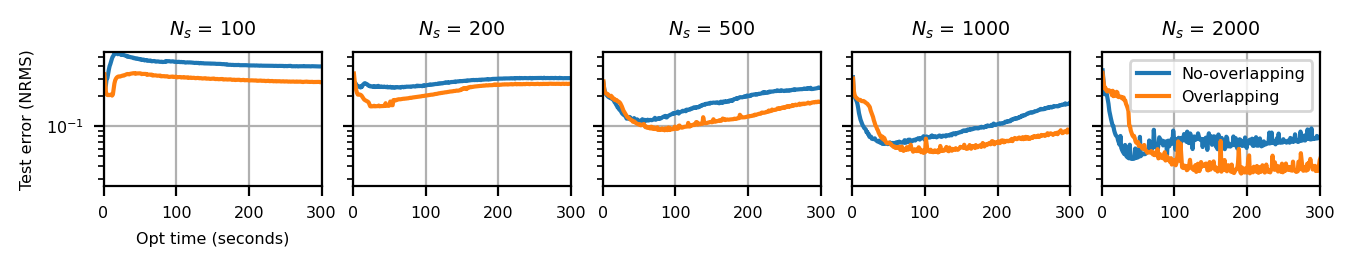

In [6]:
resultsSamples = []
Ntrains = [100,200,500,1000,2000]
for Nsamples in tqdm(Ntrains):
    resultsSamples.append(get_systems_Ndata(Nsamples,timeout=300,load=True))

plt.figure(figsize=(linewidth*2,1.2),dpi=dpi)
f = lambda x,name: plt.semilogy(x.time,x.Loss_val,label=name)

for i,(Nsamps, (sse_e_s, sse_m_s, narx_s)) in enumerate(zip(Ntrains,resultsSamples)):
    
    ax = plt.subplot(1,5,i+1)
    plt.ylim(0.025,0.55)
    plt.xlim(0,300)
#     f(narx_s,'narx')
    plt.title(f'$N_s$ = {Nsamps}')
    
    f(sse_m_s,'No-overlapping')
    f(sse_e_s,'Overlapping')
    
    
    if i==0:
        plt.ylabel('Test error (NRMS)')
        plt.xlabel('Opt time (seconds)')
    if i>0:
        ax.yaxis.set_ticklabels([])
#         ax.xaxis.set_ticklabels([])
    if i==len(resultsSamples)-1: 
        plt.legend()
    plt.grid()
plt.tight_layout(pad=pad)
plt.savefig('figs/Nsamps.pdf')
plt.show()
del resultsSamples

## Reproducability and nx (Fig. 5)

In [7]:

def get_repro_systems(nxlist, n_repeat=7, load=True, timeout=200):
    train, val, test = get_data(10000), get_data(3000), get_data(10000,noise_level=0)
    
    if load:
        return [[deepSI.load_system(systemsdir+f'reprod-enc-{nx}-{i}-last2')  for i in range(n_repeat)] for nx in nxlist]
    
    for nx in nxlist:
        for i in range(n_repeat):
            sse_e_s = deepSI.fit_systems.SS_encoder(nx=nx)
            sse_e_s.fit(train,sim_val=test,loss_kwargs=dict(nf=40),concurrent_val=True,timeout=timeout)
            sse_e_s.save_system(f'reprod-enc-{nx}-{i}-best2')
            sse_e_s.checkpoint_load_system('_last')
            sse_e_s.save_system(f'reprod-enc-{nx}-{i}-last2')
            del sse_e_s
    return [[deepSI.load_system(systemsdir+f'reprod-enc-{nx}-{i}-last2')  for i in range(n_repeat)] for nx in nxlist]



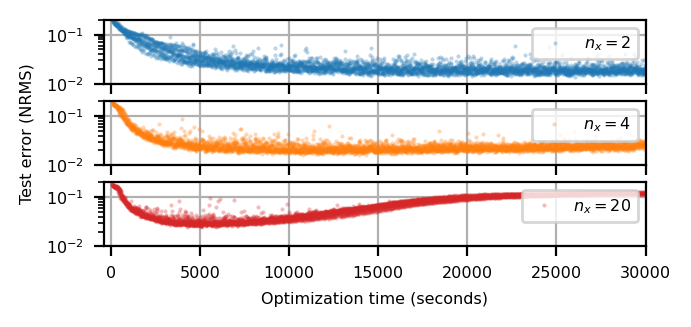

In [8]:
outrepo = get_repro_systems([2,4,20],n_repeat=7, load=True, timeout=2500)
from matplotlib import cm
plt.figure(figsize=(linewidth,1.5),dpi=dpi)
cmap = cm.get_cmap('tab10')

for i,outi in enumerate(outrepo):
    x = i/(len(outrepo)-1)
    x /= 10/3
    time = []
    loss_val = []
    col = cmap(x)
    ax = plt.subplot(3,1,i+1)
    if i<2: 
        ax.xaxis.set_ticklabels([])
    
    for k,outij in enumerate(outi):
        plt.semilogy(outij.batch_id,outij.Loss_val,'o',alpha=0.3,c=col,markersize=0.5,label=f'$n_x={outij.nx}$' if k==0 else None)
    plt.legend(loc='upper right')

    plt.xlim(-400,30000)
    plt.ylim(0.01,0.2)
    if i==1:
        plt.ylabel('Test error (NRMS)')
    plt.grid()
plt.xlabel('Optimization time (seconds)')
plt.tight_layout(pad=pad)
plt.savefig('figs/nx-repro.pdf')
plt.savefig('figs/nx-repro.jpg',dpi=600)
plt.show()
del outrepo

## $T$=`nf` parameter (Fig 3. and Fig 4.)

In [9]:
def get_nf_systems(nflist,base_epochs=100*40,load=True,last=True):
    train, val, test = get_data(10000), get_data(3000), get_data(10000,noise_level=0)
    
    if load:
        return [deepSI.load_system(systemsdir+f'enc-nf-{nf}-last') for nf in nflist]
    
    for nf in nflist:
        sse_e_s = deepSI.fit_systems.SS_encoder(nx=4)
        sse_e_s.fit(train, sim_val=test, loss_kwargs=dict(nf=nf), concurrent_val=True, timeout=1000)
        sse_e_s.save_system(f'enc-nf-{nf}-best')
        sse_e_s.checkpoint_load_system('_last')
        sse_e_s.save_system(f'enc-nf-{nf}-last')
    if last:
        return [deepSI.load_system(systemsdir+f'enc-nf-{nf}-last') for nf in nflist]
    else:
        return [deepSI.load_system(systemsdir+f'enc-nf-{nf}-best') for nf in nflist]

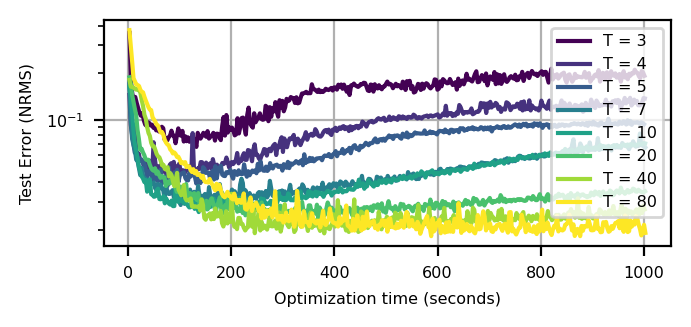

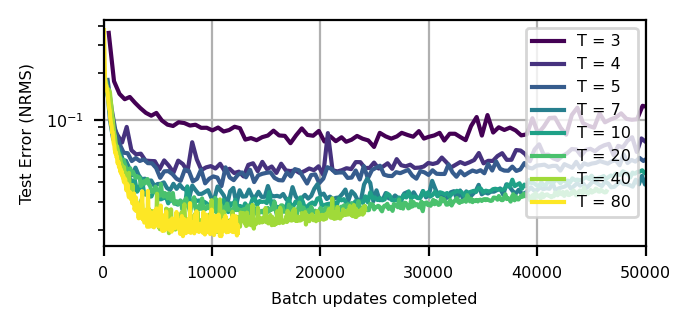

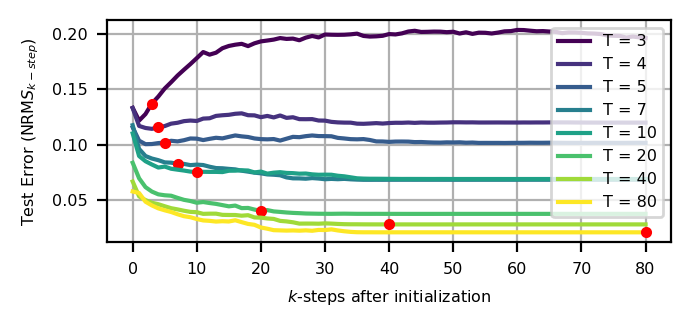

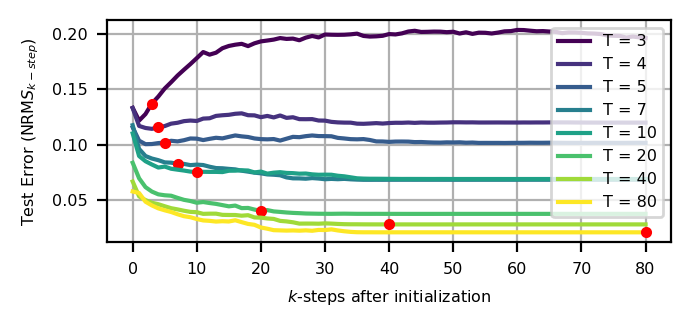

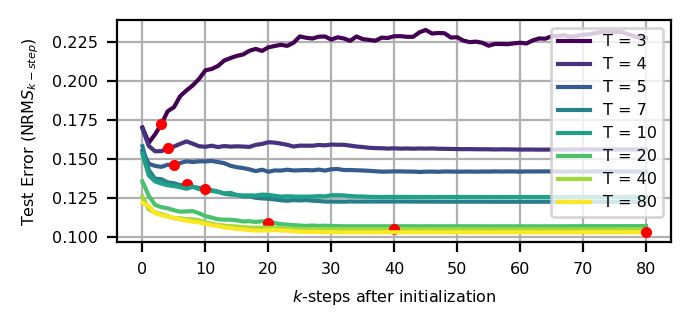

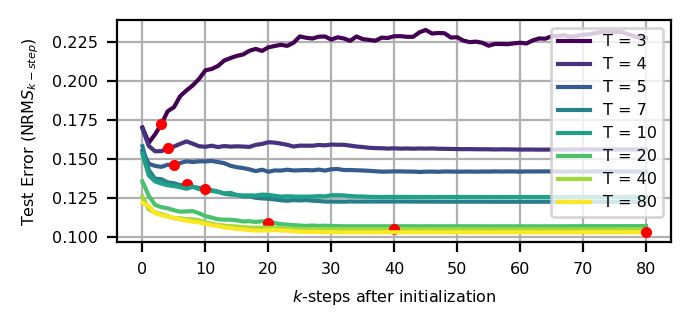

In [10]:
from matplotlib import cm
nflist = [3,4,5,7,10,20,40,80]
outnf = get_nf_systems(nflist,load=True)
# torch.save(outnf,'outnf')


cmap = cm.get_cmap('viridis')

for z,k in enumerate(['time','batch_id']):
    plt.figure(figsize=(linewidth,1.5),dpi=dpi)
    for (i,outi),nf in zip(enumerate(outnf),nflist):
        x = i/(len(outnf)-1)
        time = []
        loss_val = []
        plt.semilogy(outi.__getattribute__(k),outi.Loss_val,c=cmap(x),label='T = '+str(nf))
    plt.ylabel('Test Error (NRMS)')
    if z==0:
        plt.xlabel('Optimization time (seconds)')
    else:
        plt.xlabel('Batch updates completed')
        plt.xlim(0,50000)
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout(pad=pad)
    plt.savefig(f'figs/nf-influ-{k}.pdf')
    plt.show()

for noise_level in [0,0.1]:
    test_now = get_data(10000,noise_level=noise_level)
    for last in [True,False]:
        outnf = get_nf_systems(nflist,load=True,last=last)
        plt.figure(figsize=(linewidth,1.5),dpi=dpi)
        for (i,outi),nf in zip(enumerate(outnf),nflist):
            x = i/(len(outnf)-1)
            time = []
            loss_val = []
            outi._dt = None
            outi.feedthrough = False
            n_step_error_now = outi.n_step_error(test_now,nf=81)
            plt.plot(n_step_error_now,c=cmap(x),label='T = '+str(nf))
            plt.plot(nf,n_step_error_now[nf],'r.')
        plt.legend(loc='upper right')
        plt.grid()
        plt.xlabel('$k$-steps after initialization')
        plt.ylabel('Test Error (NRM$S_{k-step}$)')
        plt.tight_layout(pad=pad)
        plt.savefig(f'figs/nf-influ-n-step-{"last" if last else "best"}-noise-{noise_level}.pdf')
        plt.show()

del outnf

## Encoder Window Length $n=n_a=n_b$ (Fig. 6)

In [11]:
def get_na_nb_systems(nalist,load=True,timeout=1500):
    train, val, test = get_data(10000), get_data(3000), get_data(10000,noise_level=0)
    
    if load:
        return [deepSI.load_system(systemsdir+f'enc-na-{na}-last') for na in nalist]
    
    for na in nalist:
        sse_e_s = deepSI.fit_systems.SS_encoder(nx=4,na=na,nb=na)
        sse_e_s.fit(train, sim_val=test, loss_kwargs=dict(nf=40), concurrent_val=True, timeout=timeout)
        sse_e_s.save_system(f'enc-na-{na}-best')
        sse_e_s.checkpoint_load_system('_last')
        sse_e_s.save_system(f'enc-na-{na}-last')
    return [deepSI.load_system(systemsdir+f'enc-na-{na}-last') for na in nalist]

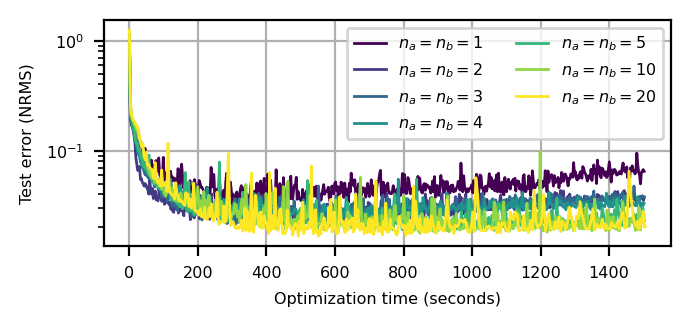

In [12]:
nalist = [1,2,3,4,5,10,20]
outna = get_na_nb_systems(nalist,load=True)
# torch.save(outna,'outna')

from matplotlib import cm
plt.figure(figsize=(linewidth,1.5),dpi=dpi)
cmap = cm.get_cmap('viridis')
# nalist = [1,2,3,4,5,10,20]


for (i,outi),na in zip(enumerate(outna),nalist):
    x = i/(len(outna)-1)
    time = []
    loss_val = []
    plt.semilogy(outi.time,outi.Loss_val,c=cmap(x),label=f'$n_a = n_b = {str(na)}$',linewidth=1)
plt.ylabel('Test error (NRMS)')
plt.xlabel('Optimization time (seconds)')
plt.legend(loc='upper right',ncol=2)
plt.grid()
plt.tight_layout(pad=pad)
plt.savefig(f'figs/nanb-fig.pdf')
plt.show()
del outna

## Network (Fig. 7)

In [13]:
def get_size_systems(nlaylist = [1,2,3,4], n_nodes_list = [2,4,8,32,128,256], timeout=300,load=True):
    train, val, test = get_data(10000), get_data(3000), get_data(10000,noise_level=0)
    
    if load:
        return [[deepSI.load_system(systemsdir+f'enc-struc-{n_lay}-{n_nodes}-last2') for n_lay in nlaylist] for n_nodes in n_nodes_list]
    
    for n_lay in tqdm(nlaylist):
        for n_nodes in tqdm(n_nodes_list):
            sse_e_s = deepSI.fit_systems.SS_encoder(nx=4)
            
            sse_e_s.e_n_hidden_layers = n_lay
            sse_e_s.e_n_nodes_per_layer = n_nodes
            sse_e_s.e_activation = nn.Tanh
            
            sse_e_s.f_n_hidden_layers = n_lay
            sse_e_s.f_n_nodes_per_layer = n_nodes
            sse_e_s.f_activation = nn.Tanh
            
            sse_e_s.h_n_hidden_layers = n_lay
            sse_e_s.h_n_nodes_per_layer = n_nodes
            sse_e_s.h_activation = nn.Tanh
            
#             sse_e_s = deepSI.load_system(systemsdir+f'enc-struc-{n_lay}-{n_nodes}-best')
            sse_e_s.fit(train, sim_val=test, loss_kwargs=dict(nf=40), concurrent_val=True, timeout=timeout, verbose=0)
            sse_e_s.save_system(f'enc-struc-{n_lay}-{n_nodes}-best2')
            sse_e_s.checkpoint_load_system('_last')
            sse_e_s.save_system(f'enc-struc-{n_lay}-{n_nodes}-last2')
    return [[deepSI.load_system(systemsdir+f'enc-struc-{n_lay}-{n_nodes}-last2') for n_lay in nlaylist] for n_nodes in n_nodes_list]

In [14]:
outstruc = get_size_systems(timeout=2000,load=True)

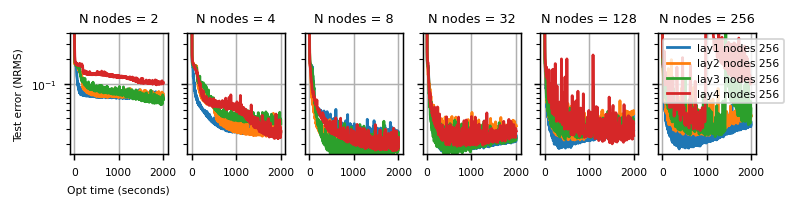

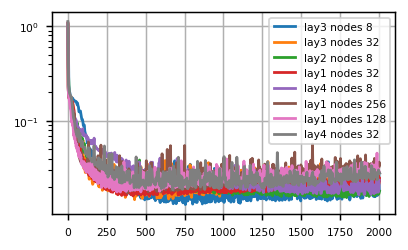

In [15]:
from matplotlib import cm

cmap = cm.get_cmap('viridis')

minvals = [[np.min(outi.Loss_val) for outi in outj] for outj in outstruc]


plt.figure(figsize=(linewidth*2,1.2),dpi=dpi/1.5)
for z,outj in enumerate(outstruc):
    ax = plt.subplot(1,6,z+1)
    for i,outi in enumerate(outj):
        x = i/(len(outj)-1)
#         plt.plot(outi.time,outi.Loss_val,c=cmap(x),label=str(outi.e_n_hidden_layers)+' '+str(outi.e_n_nodes_per_layer))
        plt.semilogy(outi.time,np.array(outi.Loss_val),label='lay'+str(outi.e_n_hidden_layers)+' nodes '+str(outi.e_n_nodes_per_layer))
    
    plt.title(f'N nodes = {outi.e_n_nodes_per_layer}')
    plt.grid()
    plt.ylim(0.015,0.4)
    if z==0:
        plt.ylabel('Test error (NRMS)')
        plt.xlabel('Opt time (seconds)')
    if z>0:
        ax.yaxis.set_ticklabels([])
#         ax.xaxis.set_ticklabels([])
plt.legend()
plt.show()

outsub = sorted(np.array(outstruc).flatten(),key=lambda x: min(x.Loss_val))[:8]

plt.figure(figsize=(linewidth,2),dpi=dpi/1.5)
for outi in outsub:
    plt.semilogy(outi.time,outi.Loss_val,label='lay'+str(outi.e_n_hidden_layers)+' nodes '+str(outi.e_n_nodes_per_layer))
plt.legend()
plt.grid()
plt.show()
# del outstruc

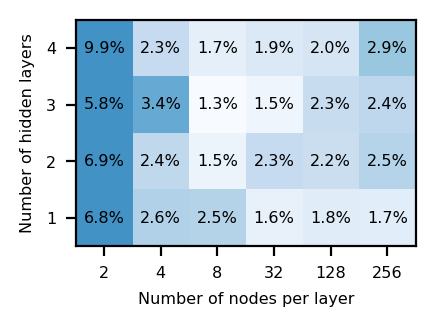

In [16]:
import matplotlib.patheffects as path_effects
fig, ax = plt.subplots(figsize=(linewidth*0.75,2*0.75),dpi=dpi)

min_val, max_val = 0, 15

minvals = np.transpose([[np.min(outi.Loss_val) for outi in outj] for outj in outstruc])
# minvals = [[outi.time[np.argmin(outi.Loss_val)]/2000 for outi in outj] for outj in outstruc]


intersection_matrix = np.array(minvals) #np.random.randint(0, 10, size=(max_val, max_val))
M = 0.038
ax.matshow(np.clip(intersection_matrix, 0, M), cmap=plt.cm.Blues, origin='lower',vmax=M*1.4)

for i in range(intersection_matrix.shape[1]):
    for j in range(intersection_matrix.shape[0]):
        c = intersection_matrix[j,i]
        tx = ax.text(i, j, f'{c:.1%}', va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
ax.set_yticks(np.arange(len(outstruc[0])))
ax.set_yticklabels([str(o.e_n_hidden_layers) for o in outstruc[0]])
ax.set_xticks(np.arange(len(outstruc)))
ax.set_xticklabels([str(o[0].e_n_nodes_per_layer) for o in outstruc])
plt.xlabel('Number of nodes per layer')
plt.ylabel('Number of hidden layers')
# plt.grid()
plt.tight_layout(pad=pad)
plt.savefig(f'figs/struc.pdf')
plt.show()

## Batchsize (No figure, results only suggested in paper)

In [17]:
def get_batchsize_systems(batchsizes,noise_level=0.1,timeout=100,add='',load=True):
    train, test = get_data(10000,noise_level=noise_level), get_data(10000,noise_level=0)
    
    if load:
        return [deepSI.load_system(systemsdir+f'enc-bat-{batch_size}{add}-last') for batch_size in batchsizes]
    
    for batch_size in batchsizes:
        sse_e_s = deepSI.fit_systems.SS_encoder(nx=4)
        sse_e_s.fit(train, sim_val=test, loss_kwargs=dict(nf=40), concurrent_val=True, timeout=timeout,batch_size=batch_size)
        sse_e_s.save_system(f'enc-bat-{batch_size}{add}-best')
        sse_e_s.checkpoint_load_system('_last')
        sse_e_s.save_system(f'enc-bat-{batch_size}{add}-last')
    return [deepSI.load_system(systemsdir+f'enc-bat-{batch_size}{add}-last') for batch_size in batchsizes]

In [18]:
batchsizes = [4,16,64,128,512,2048,9961]
timeout = 2000
outbatch = get_batchsize_systems(batchsizes,timeout=timeout,load=True)

4 0.028335208123621714
16 0.025387938185498986
64 0.020055364002876528
128 0.01776581997401799
512 0.017133102905933627
2048 0.016255425592695633
9961 0.03149058812661633


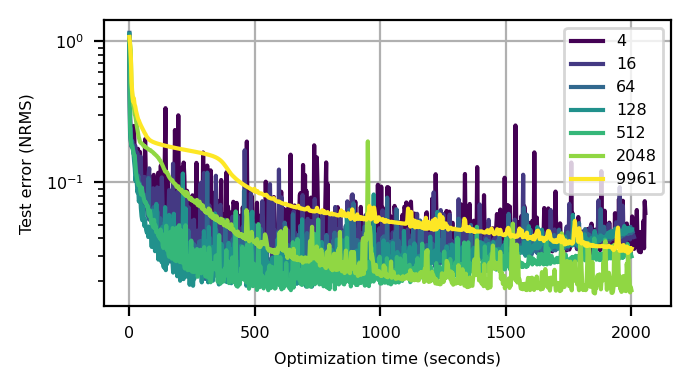

In [19]:


from matplotlib import cm
plt.figure(figsize=(linewidth,1.8),dpi=dpi)
cmap = cm.get_cmap('viridis')

for (i,outi),bat in zip(enumerate(outbatch),batchsizes):
    print(bat, min(outi.Loss_val))
    x = i/(len(outbatch)-1)
    plt.semilogy(outi.time,outi.Loss_val,c=cmap(x),label=str(bat))
plt.ylabel('Test error (NRMS)')
plt.xlabel('Optimization time (seconds)')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout(pad=pad)
plt.savefig(f'figs/batch-size-time.pdf')
plt.show()
del outbatch

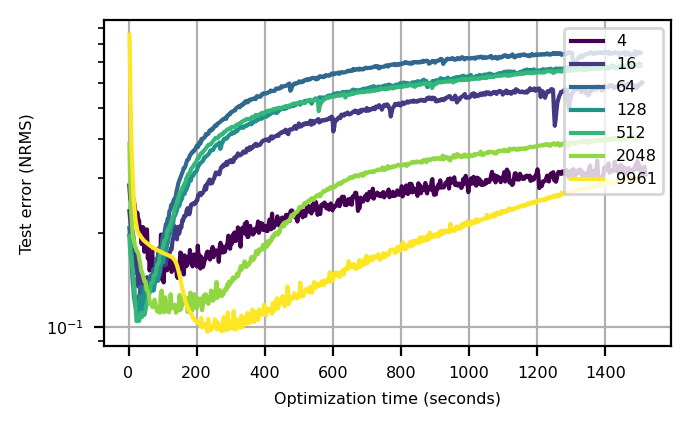

In [20]:
batchsizes = [4,16,64,128,512,2048,9961]
timeout = 1500
outbatchhighnoise = get_batchsize_systems(batchsizes,timeout=timeout,noise_level=1.0,add='n',load=True)#high noise level

from matplotlib import cm
plt.figure(figsize=(linewidth,2),dpi=dpi)
cmap = cm.get_cmap('viridis')


for (i,outi),bat in zip(enumerate(outbatchhighnoise),batchsizes):
    x = i/(len(outbatchhighnoise)-1)
    plt.semilogy(outi.time,outi.Loss_val,c=cmap(x),label=str(bat))
plt.ylabel('Test error (NRMS)')
plt.xlabel('Optimization time (seconds)')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout(pad=pad)
plt.savefig(f'figs/batch-size-time-high-noise.pdf')
plt.show()
del outbatchhighnoise

## Noise Amplitude (Not included in paper)

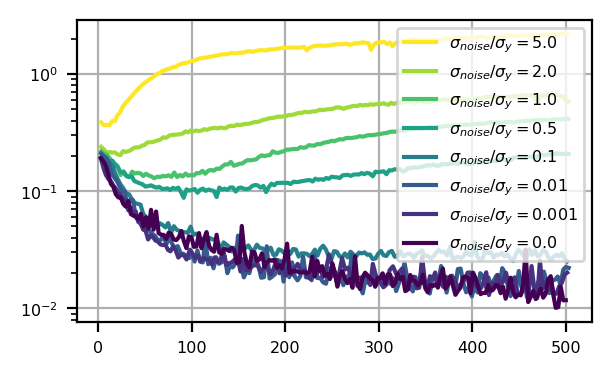

In [21]:
def get_noise_systems(noise_levels = [0.0,1e-2,0.1,0.4,1.0,2.0,5.0],timeout=300, load=True):
    test = get_data(10000,noise_level=0)
    
    if load:
        return [deepSI.load_system(systemsdir+f'enc-noise-{noise_l}-last') for noise_l in noise_levels]
    
    for noise_l in noise_levels:
        train = get_data(10000,noise_level=noise_l)
        sse_e_s = deepSI.fit_systems.SS_encoder(nx=4)
        sse_e_s.fit(train, sim_val=test, loss_kwargs=dict(nf=40), concurrent_val=True, timeout=timeout)
        sse_e_s.save_system(f'enc-noise-{noise_l}-best')
        sse_e_s.checkpoint_load_system('_last')
        sse_e_s.save_system(f'enc-noise-{noise_l}-last')
    return [deepSI.load_system(systemsdir+f'enc-noise-{noise_l}-last') for noise_l in noise_levels]

noise_levels = [0.0,1e-3,1e-2,0.1,0.5,1.0,2.0,5.0]
outnoise = get_noise_systems(noise_levels=noise_levels,timeout=500,load=True)


from matplotlib import cm
plt.figure(figsize=(linewidth,2),dpi=dpi)
cmap = cm.get_cmap('viridis')

for (i,outi),noise_l in zip(enumerate(outnoise[::-1]),noise_levels[::-1]):
    x = 1-i/(len(outnoise)-1)
    time = []
    loss_val = []
    plt.semilogy(outi.time,outi.Loss_val,c=cmap(x),label=r'$\sigma_{noise}/\sigma_y = $'+str(noise_l))
plt.legend(loc='upper right')
plt.grid()
plt.show()
del outnoise

## Linear Innovation noise process (Table 2)

In [22]:

class My_system_ino(deepSI.System_ss): 
    def __init__(self,noise_level=0.1,K0 = np.array([1,-0.9]), K_level=1.0):
        Knorm = np.array(K0)/(np.sum(K0**2)**0.5) #Knorm has a norm of 1
        super(My_system_ino,self).__init__(nx=3)
        self.K = K_level*Knorm
        self.noise_amp = 0.8220855854410254 * noise_level #ystd*noise_level
    def f(self, x, u):
        x1new = x[0]/(1.2+x[1]**2)+x[1]*0.4     + self.K[0]*x[2]
        x2new = x[1]/(1.2+x[0]**2)+x[0]*0.4 + u + self.K[1]*x[2]
        noise_new = np.random.normal(scale=self.noise_amp)
        return x1new, x2new, noise_new
    def h(self, x, u):
        return x[0]  + x[2] #add some noise#add some noise
    
def get_ino_data(Nsamples,noise_level=0.1,K_level=1.0,K0=[1,-0.9]):
    base_sys = My_system_ino(noise_level=noise_level,K_level=K_level)
    data = base_sys.apply_experiment(deepSI.System_data(u=np.random.uniform(low=-2,high=2,size=Nsamples)))
    return data

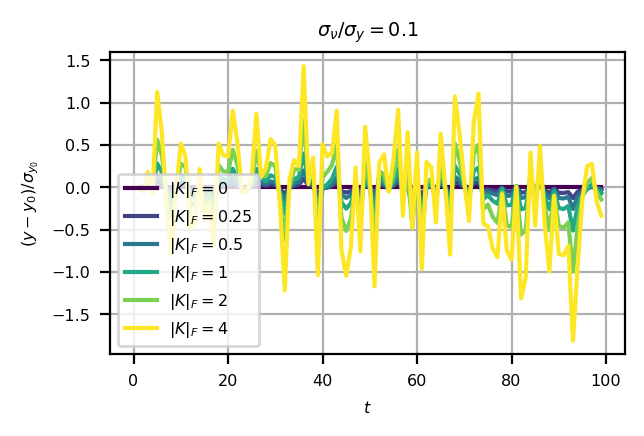

In [23]:

#showcase on influence of klevel
Klevels = [0,0.25,0.5,1,2,4]
plt.figure(figsize=(linewidth,2),dpi=dpi)
N = 100
cmap = cm.get_cmap('viridis')
noise_level0 = 0.2

np.random.seed(42)
noise0 = get_ino_data(N,K_level=0,noise_level=noise_level0)
for i,Kl in enumerate(Klevels):
    x = i/(len(Klevels)-1)
    np.random.seed(42)
    plt.plot((noise0.y-get_ino_data(N,noise_level=noise_level0,K_level=Kl).y)/0.8220855854410254,c=cmap(x),label='$|K|_F = $' + str(Kl))
plt.legend()
plt.title(r'$\sigma_\nu/\sigma_y = 0.1$')
plt.xlabel('$t$')
plt.ylabel('$(y-y_0)/\\sigma_{y_0}$')
plt.grid()
plt.show()

In [24]:
def get_ino_systems(Klevels=[0,1,2,5,10],timeout=300,load=True, name='last', name2='',get_data = get_ino_data, instances=1):
    def loadfun():
        base_e = [[deepSI.load_system(systemsdir+f'enc-{name2}ino-noK-{Kl}-{name}{"" if i==0 else i}') for i in range(instances)] for Kl in Klevels]
        ino_e = [[deepSI.load_system(systemsdir+f'enc-{name2}ino-K-{Kl}-{name}{"" if i==0 else i}') for i in range(instances)] for Kl in Klevels]
        ino_nl_e = [[deepSI.load_system(systemsdir+f'enc-{name2}ino-Knonlin-{Kl}-{name}{"" if i==0 else i}') for i in range(instances)] for Kl in Klevels]
        return base_e, ino_e, ino_nl_e
    
    test = get_data(10000,noise_level=0)
    
    if load:
        return loadfun()
    
    for i in range(1,instances):
        if i==0:
            i=''
        for Kl in Klevels:
            train = get_data(10000,K_level=Kl)

            sse_e_s = deepSI.fit_systems.SS_encoder_general(nx=4, na_right=1)
            sse_e_s.fit(train, test, loss_kwargs=dict(nf=40), concurrent_val=True, timeout=timeout)
            sse_e_s.save_system(systemsdir+f'enc-{name2}ino-noK-{Kl}-best{i}')
            sse_e_s.checkpoint_load_system('_last')
            sse_e_s.save_system(systemsdir+f'enc-{name2}ino-noK-{Kl}-last{i}')

            sse_e_s = deepSI.fit_systems.SS_encoder_inovation(nx=4, na_right=1)
            sse_e_s.fit(train, test, loss_kwargs=dict(nf=40), concurrent_val=True, timeout=timeout)
            sse_e_s.save_system(systemsdir+f'enc-{name2}ino-K-{Kl}-best{i}')
            sse_e_s.checkpoint_load_system('_last')
            sse_e_s.save_system(systemsdir+f'enc-{name2}ino-K-{Kl}-last{i}')

            from inostatenets import nonlin_ino_state_net
            sse_e_s = deepSI.fit_systems.SS_encoder_inovation(nx=4,f_net=nonlin_ino_state_net, na_right=1)
            sse_e_s.fit(train, test, loss_kwargs=dict(nf=40), concurrent_val=True, timeout=timeout)
            sse_e_s.save_system(systemsdir+f'enc-{name2}ino-Knonlin-{Kl}-best{i}')
            sse_e_s.checkpoint_load_system('_last')
            sse_e_s.save_system(systemsdir+f'enc-{name2}ino-Knonlin-{Kl}-last{i}')

    return loadfun()

In [25]:
Klevels=[0,0.25,0.5,1,2,4]
base_e, ino_e, ino_nl_e = get_ino_systems(Klevels=Klevels, timeout=500, load=True, instances=4, name='best')

to_min_loss = lambda x: [[np.min(ai.Loss_val) for ai in a] for a in x]
mean_std = lambda x: [(np.mean(a), np.std(a)/np.sqrt(len(a))) for a in to_min_loss(x)]
strings = lambda x: [f"{a[0]*100:.1f}±{a[1]*100:.1f}" for a in mean_std(x)]
A = [[f'{float(Kl):.2}' for Kl in Klevels]]+[strings(b) for b in [base_e, ino_e, ino_nl_e]]
A = [['Sigma_k', 'OE noise', 'Linear \ninnovation \nnoise', 'Nonlinear \ninnovation \nnoise']] + list(zip(*A))
from tabulate import tabulate
print(tabulate(A,tablefmt='latex'))

\begin{tabular}{llll}
\hline
 Sigma\_k & OE noise & Linear 
innovation 
noise         & Nonlinear 
innovation 
noise         \\
 0.0     & 1.8±0.1  & 1.7±0.1 & 1.8±0.1 \\
 0.25    & 2.1±0.2  & 1.9±0.1 & 2.1±0.1 \\
 0.5     & 2.3±0.1  & 1.9±0.1 & 2.1±0.1 \\
 1.0     & 3.2±0.1  & 2.2±0.1 & 2.0±0.2 \\
 2.0     & 4.8±0.1  & 3.0±0.1 & 2.5±0.0 \\
 4.0     & 8.4±0.3  & 5.7±0.4 & 4.4±0.1 \\
\hline
\end{tabular}


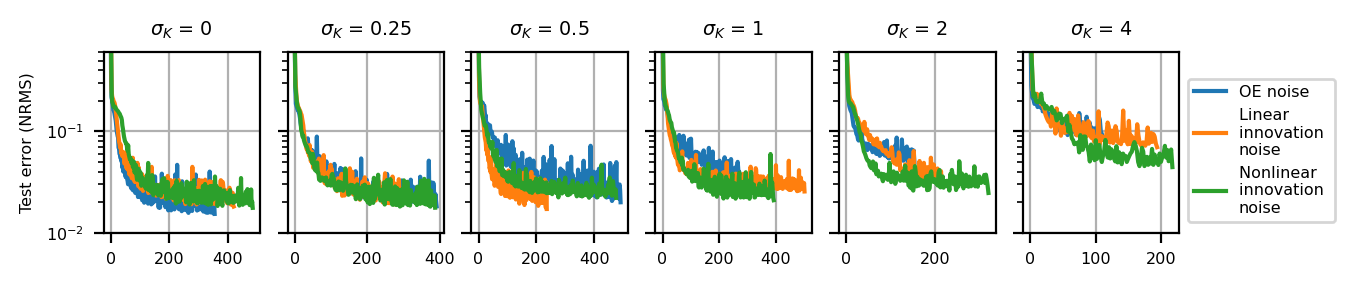

In [26]:
plt.figure(figsize=(linewidth*2,1.3),dpi=dpi)
cmap = cm.get_cmap('viridis')

for (i,(be,ie,ige)),Kl in zip(enumerate(zip(base_e, ino_e, ino_nl_e)),Klevels):
#     x = i/(len(base_e)-1)

    ax = plt.subplot(1,len(base_e),i+1)
    plt.ylim(0.01,0.6)
    time = []
    loss_val = []
    plt.title('$\sigma_K$ = '+str(Kl))
    plt.semilogy(be[0].time,be[0].Loss_val,label='OE noise')
    plt.semilogy(ie[0].time,ie[0].Loss_val,label='Linear \ninnovation \nnoise')
    plt.semilogy(ige[0].time,ige[0].Loss_val,label='Nonlinear \ninnovation \nnoise')
    if i==0:
        plt.ylabel('Test error (NRMS)')
    if i>0:
        ax.yaxis.set_ticklabels([])
#         ax.xaxis.set_ticklabels([])
    if i==len(base_e)-1: 
        plt.legend(bbox_to_anchor=(1.0, 0.9))
    plt.grid()
plt.tight_layout(pad=pad)
plt.savefig(f'figs/inno-encoder.pdf')
plt.show()
# del base_e, ino_e, ino_nl_e

In [27]:
# S = [[f'{float(Kl):.2}',f'{min(be[0].Loss_val):.1%}',f'{min(ie[0].Loss_val):.1%}',f'{min(ige[0].Loss_val):.1%}'] for (i,(be,ie,ige)),Kl in list(zip(enumerate(zip(base_e, ino_e,ino_nl_e)),Klevels))]
# S2 = [['Sigma_k', 'OE noise', 'Linear \ninnovation \nnoise', 'Nonlinear \ninnovation \nnoise']] + S
# print(tabulate(S2,tablefmt='latex'))

## Non-linear Innovation noise process (Table 3)

In [28]:
class My_system_ino_nonlin(deepSI.System_ss): 
    def __init__(self,noise_level=0.1,K0 = np.array([1,-0.9]), K_level=1.0):
        Knorm = np.array(K0)/(np.sum(K0**2)**0.5) #Knorm has a norm of 1
        super(My_system_ino_nonlin,self).__init__(nx=3)
        self.K = K_level*Knorm
        self.noise_amp = 0.8220855854410254 * noise_level #ystd*noise_level
    def f(self, x, u):
        e = x[2]
        x1new = x[0]/(1.2+x[1]**2)+x[1]*0.4     + x[0]*self.K[0]*e
        x2new = x[1]/(1.2+x[0]**2)+x[0]*0.4 + u + x[1]*self.K[1]*e
        noise_new = np.random.normal(scale=self.noise_amp)
        return x1new, x2new, noise_new
    def h(self, x, u):
        return x[0]  + x[2] #add some noise
    
def get_ino_data_nonlin(Nsamples,noise_level=0.1,K_level=1.0,K0=[1,-0.9]):
    base_sys = My_system_ino_nonlin(noise_level=noise_level,K_level=K_level)
    data = base_sys.apply_experiment(deepSI.System_data(u=np.random.uniform(low=-2,high=2,size=Nsamples)))
    return data


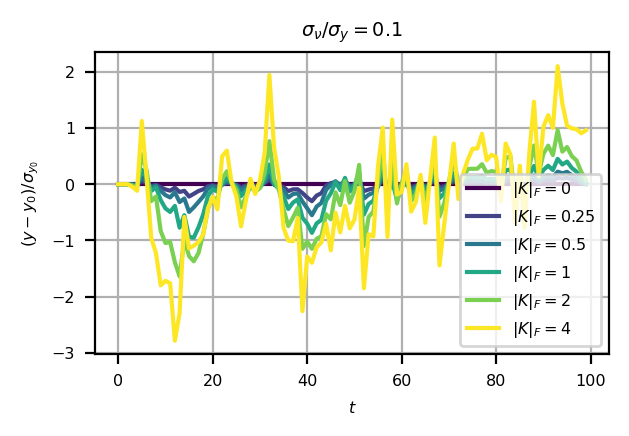

In [29]:

#showcase on influence of klevel
Klevels = [0,0.25,0.5,1,2,4]
plt.figure(figsize=(linewidth,2),dpi=dpi)
N = 100
cmap = cm.get_cmap('viridis')
noise_level0 = 0.2

np.random.seed(42)
f = get_ino_data_nonlin
noise0 = f(N,K_level=0,noise_level=noise_level0)
for i,Kl in enumerate(Klevels):
    x = i/(len(Klevels)-1)
    np.random.seed(42)
    plt.plot((noise0.y-f(N,noise_level=noise_level0,K_level=Kl).y)/0.8220855854410254,c=cmap(x),label='$|K|_F = $' + str(Kl))
plt.legend()
plt.title(r'$\sigma_\nu/\sigma_y = 0.1$')
plt.xlabel('$t$')
plt.ylabel('$(y-y_0)/\\sigma_{y_0}$')
plt.grid()
plt.show()

In [30]:
# Klevels=[0.25]
# base_e, ino_e, ino_nl_e = get_ino_systems(Klevels=Klevels, name2='nonlin', timeout=500, load=False, get_data=get_ino_data_nonlin)
Klevels=[0,0.25,0.5,1,2,4]
base_e, ino_e, ino_nl_e = get_ino_systems(Klevels=Klevels, name2='nonlin', timeout=500, \
                                          load=True, get_data=get_ino_data_nonlin, instances=4)


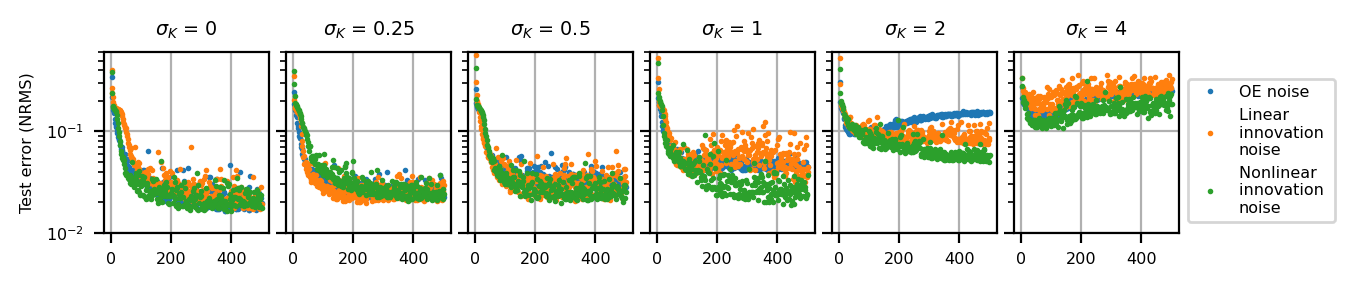

In [31]:
Klevels=[0,0.25,0.5,1,2,4]
base_e, ino_e, ino_nl_e = get_ino_systems(Klevels=Klevels, name2='nonlin', timeout=500, \
                                          load=True, get_data=get_ino_data_nonlin, instances=4)

plt.figure(figsize=(linewidth*2,1.3),dpi=dpi)
cmap = cm.get_cmap('viridis')

for (i,(be,ie,ige)),Kl in zip(enumerate(zip(base_e, ino_e,ino_nl_e)),Klevels):
#     x = i/(len(base_e)-1)

    ax = plt.subplot(1,len(base_e),i+1)
    plt.ylim(0.01,0.6)
    time = []
    loss_val = []
    plt.title('$\sigma_K$ = '+str(Kl))
    plt.semilogy(be[0].time,be[0].Loss_val,'.',label='OE noise',markersize=2)
    plt.semilogy(ie[0].time,ie[0].Loss_val,'.',label='Linear \ninnovation \nnoise',markersize=2)
    plt.semilogy(ige[0].time,ige[0].Loss_val,'.',label='Nonlinear \ninnovation \nnoise',markersize=2)
    if i==0:
        plt.ylabel('Test error (NRMS)')
    if i>0:
        ax.yaxis.set_ticklabels([])
#         ax.xaxis.set_ticklabels([])
    if i==len(base_e)-1: 
        plt.legend(bbox_to_anchor=(1.0, 0.9))
    plt.grid()
plt.tight_layout(pad=pad)
plt.savefig(f'figs/inno-encoder-nonlin.pdf')
plt.show()


In [32]:
base_e, ino_e, ino_nl_e = get_ino_systems(Klevels=Klevels, name2='nonlin', timeout=500, load=True, get_data=get_ino_data_nonlin, instances=4)
to_min_loss = lambda x: [[np.min(ai.Loss_val) for ai in a] for a in x]
mean_std = lambda x: [(np.mean(a), np.std(a)/np.sqrt(len(a))) for a in to_min_loss(x)]
strings = lambda x: [f"{a[0]*100:.1f}±{a[1]*100:.1f}" for a in mean_std(x)]
A = [[f'{float(Kl):.2}' for Kl in Klevels]]+[strings(b) for b in [base_e, ino_e, ino_nl_e]]
A = [['Sigma_k', 'OE noise', 'Linear \ninnovation \nnoise', 'Nonlinear \ninnovation \nnoise']] + list(zip(*A))
print(tabulate(A,tablefmt='latex'))

\begin{tabular}{llll}
\hline
 Sigma\_k & OE noise & Linear 
innovation 
noise          & Nonlinear 
innovation 
noise          \\
 0.0     & 1.8±0.1  & 1.7±0.0  & 1.8±0.1  \\
 0.25    & 2.2±0.1  & 2.2±0.1  & 1.8±0.1  \\
 0.5     & 2.8±0.1  & 2.4±0.1  & 1.8±0.1  \\
 1.0     & 4.1±0.1  & 3.2±0.1  & 2.3±0.2  \\
 2.0     & 8.2±0.3  & 6.5±0.4  & 4.3±0.3  \\
 4.0     & 14.2±0.8 & 12.6±0.6 & 10.5±0.3 \\
\hline
\end{tabular}
